In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


# Triple Junctions
In this notebook we discuss the approach to dealing with 3 fault elements meeting at a point aka a triple junction. In plate kinematics, we deal with triple junctions by imposing that the slip vector at the triple junction is a conserved vector quantity i.e., 
$\begin{equation}
\underline{s}_1 + \underline{s}_2 + \underline{s}_3 = 0
\end{equation}$

Note in the above equation the sign of the slip vector depends on the circulation and directions of the unit normal vectors to each fault element. Below we start by constructing a 3-fault triple junction. 

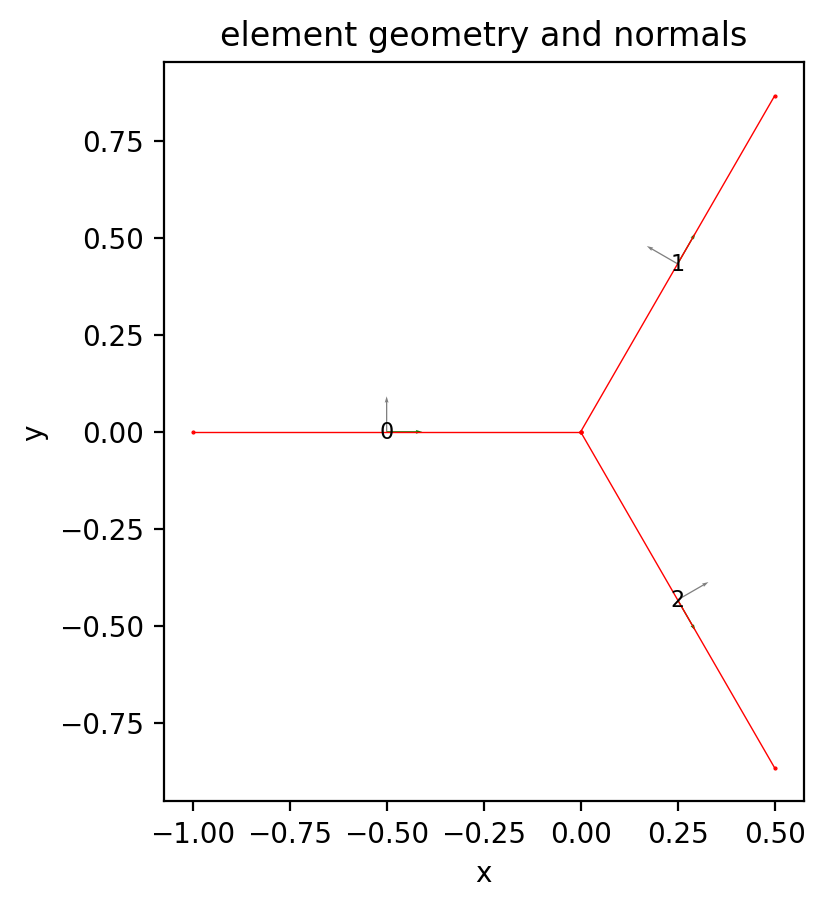

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# Triple junction geometry
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0])
els.x2 = np.array([0.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(60))])
# els.x2 = np.array([0.0, np.cos(np.deg2rad(0)), np.cos(np.deg2rad(60))])
els.y1 = np.array([0.0, 0.0, 0.0])
els.y2 = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(60))])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# TODO: DO these normals make sense.  They do with a RHR but don't seem to circulate.

# Specify slip vector on all three elements
We specify the values of the slip vector here. These are important for the linear operator and boundary conditions that we need. 

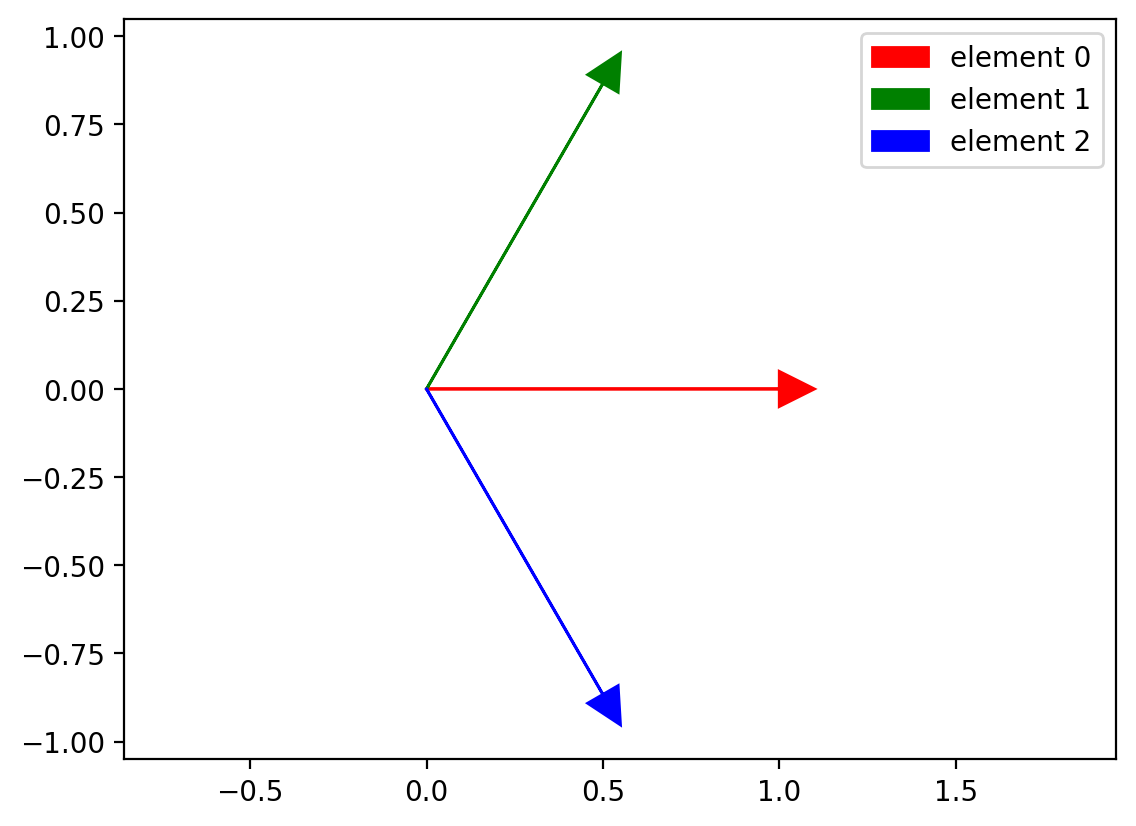

In [3]:
# A maybe set of kinematically consistent slip rates
slip_x_vec = np.array([1.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(60))])
slip_y_vec = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(60))])

# slip_x_vec = np.array([1.0, 1.0, 1.0])
# slip_y_vec = np.array([0.0, 0.0, 0.0])


# slip_x_vec = np.array([1.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(10))])
# slip_y_vec = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(10))])


# A probably not set of kinematically consistent slip rates
# slip_x_vec = np.array([1.0, 1, np.cos(np.deg2rad(60))])
# slip_y_vec = np.array([0.0, np.sin(np.deg2rad(60)), 0])


plt.figure()
plt.arrow(
    0,
    0,
    slip_x_vec[0],
    slip_y_vec[0],
    head_width=0.1,
    head_length=0.1,
    color="r",
    label="element 0",
)
plt.arrow(
    0,
    0,
    slip_x_vec[1],
    slip_y_vec[1],
    head_width=0.1,
    head_length=0.1,
    color="g",
    label="element 1",
)
plt.arrow(
    0,
    0,
    slip_x_vec[2],
    slip_y_vec[2],
    head_width=0.1,
    head_length=0.1,
    color="b",
    label="element 2",
)
plt.legend()
plt.axis("equal")
plt.show()

# Get linear operators that will be used to build the linear operator

In [4]:
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
slip_mean_mat, _ = bemcs.get_matrices_slip_slip_gradient(els, flag="mean")

# Linear operator and boundary conditions
For $N = 3$ elements, each having three nodes ($n_1$, $n_2$, and $n_3$), giving us have $18$ equations. The linear operator that contains these equations itself has 4 different types of equations:
- Slip values (specified as either nodal or mean values) for the central node ($n_2$) of every element
- Slip values for the open nodes ($n_1$ or $n_3$) is set to $0$. The open nodes in this system are $p_1(n_1)$, $p_2(n_3)$, and $p_3(n_3)$.

# Boundary condtions we're pretty sure of:
| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 1   | $p^x_1(n_1) = 0$     | element 1: $x$ slip at open node    |
| 2   | $p^y_1(n_1) = 0$     | element 1: $y$ slip at open node    |
| 3   | $p^x_1(n_2) = u^x_1$ | element 1: $x$ slip at central node |
| 4   | $p^y_1(n_2) = u^y_1$ | element 1: $y$ slip at central node |
| 5   | $p^x_2(n_3) = 0$     | element 2: $x$ slip at open node    |
| 6   | $p^y_2(n_3) = 0$     | element 2: $y$ slip at open node    |
| 7   | $p^x_2(n_2) = u^x_2$ | element 2: $x$ slip at central node |
| 8   | $p^y_2(n_2) = u^y_2$ | element 2: $y$ slip at central node |
| 9   | $p^x_3(n_3) = 0$     | element 3: $x$ slip at open node    |
| 10  | $p^y_3(n_3) = 0$     | element 3: $y$ slip at open node    |
| 11  | $p^x_3(n_2) = u^x_3$ | element 3: $x$ slip at central node |
| 12  | $p^y_3(n_2) = u^y_3$ | element 3: $y$ slip at central node |

# We need six more equations and there seem to be several options


# Case A
- Continuity of slip at a triple junction 
- Smoothness of slip between any 2 elements that share a common node (this is questionable)

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $\partial p^x_1(n_3) / \partial x - \partial p^x_2(n_1) / \partial x = 0$ | elements 1, 2: continuity of $x$ slip gradient at a triple junction |
| 16  | $\partial p^y_1(n_3) / \partial y - \partial p^y_2(n_1) / \partial y = 0$ | elements 1, 2: continuity of $y$ slip gradient at a triple junction |
| 17  | $\partial p^x_1(n_3) / \partial x - \partial p^x_3(n_1) / \partial x = 0$ | elements 1, 3: continuity of $x$ slip gradient at a triple junction |
| 18  | $\partial p^y_1(n_3) / \partial y - \partial p^y_3(n_1) / \partial y = 0$ | elements 1, 3: continuity of $y$ slip gradient at a triple junction |

#### Pros:
- Non-singular

#### Cons:
- Stresses are not continuous at triple junction!!!

#### Notes:
- Does slip actually vary smoothly from element to element at the triple junction?  I'm asking this because the displacement as a function x figure looks non-smooth at the triple junction.  Also equation 15-18 cover the 1-2 and 1-3 smoothness case but what about the 2-3 case?  We could write the 2-3 case but I think you mentioned that this would be redundant?


In [5]:
stride = 6
n_equations = stride * n_els
n_unknowns = stride * n_els
slip_system_mat = np.zeros((n_equations, n_unknowns))

bc_vec = np.zeros((n_equations, 1))
bc_vec[2::6] = slip_x_vec.reshape((-1, 1))
bc_vec[3::6] = slip_y_vec.reshape((-1, 1))

# Linear operator for BCs as a matrix
# Boundary nodes (set to 0 slip)
slip_system_mat[0:2, :] = slip_mat[0:2:]  # first element open node
slip_system_mat[10:12, :] = slip_mat[10:12:]  # second element open node
slip_system_mat[16:18, :] = slip_mat[16:18, :]  # last element open node

# Center nodes (for x,y components)
slip_system_mat[2::6, :] = slip_mat[2::6, :]  # x component
slip_system_mat[3::6, :] = slip_mat[3::6, :]  # y component

# Overlapping interior nodes (apply slip continuity and smoothness)
# Triple junction equation of continuity
slip_system_mat[4, :] = slip_mat[4, :] - slip_mat[6, :] - slip_mat[12, :]  # x component
slip_system_mat[5, :] = slip_mat[5, :] - slip_mat[7, :] - slip_mat[13, :]  # y component

# Smoothness (applied 2 elements at a time)
slip_system_mat[6, :] = slip_gradient_mat[4, :] - slip_gradient_mat[6, :]
slip_system_mat[7, :] = slip_gradient_mat[5, :] - slip_gradient_mat[7, :]
slip_system_mat[12, :] = slip_gradient_mat[4, :] - slip_gradient_mat[12, :]
slip_system_mat[13, :] = slip_gradient_mat[5, :] - slip_gradient_mat[13, :]

# Plot system matrix
plt.figure()
pc = plt.pcolor(slip_system_mat, cmap="coolwarm", shading="flat")
plt.grid(which="both")
plt.gca().invert_yaxis()
pc.set_clim(-2, 2)
plt.colorbar(pc)
plt.show()

# Solve the system
# Compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(slip_system_mat) @ bc_vec
print("Linear operator condition number:", np.linalg.cond(slip_system_mat))

# Extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[
        stride * i : stride * i + 3
    ]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[
        stride * i + 3 : stride * (i + 1)
    ]

Linear operator condition number: 33.111095674119376


#### Case A: Displacements and stresses
When I first plotted this, it looked like the slip smoothness condition does not completely remove the singularity at the triple junction. But after thinking about it some more, I am coming to realize that it is probably okay. The reason there are discontinuities in stress is because the traction vector is continuous at the triple junction, but that does not guarantee that stresses should be too.

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:148: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:682: RuntimeWarning: divide by zero encountered in divide
  3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:760: RuntimeWarning: divide by zero encountered in divide
  1
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:833: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:912: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1003: RuntimeWarning: divide by zero encountered in divide
  1
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1087: RuntimeWarning: divide by zero encountered in divide
  -3
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:1425: RuntimeWarning: invalid value encountered in multiply
  ) + 2 * y_component * mu * (-f[4, :] + y * f[6, :])
/Users/meade/Desktop/bemcs/bemcs/bem

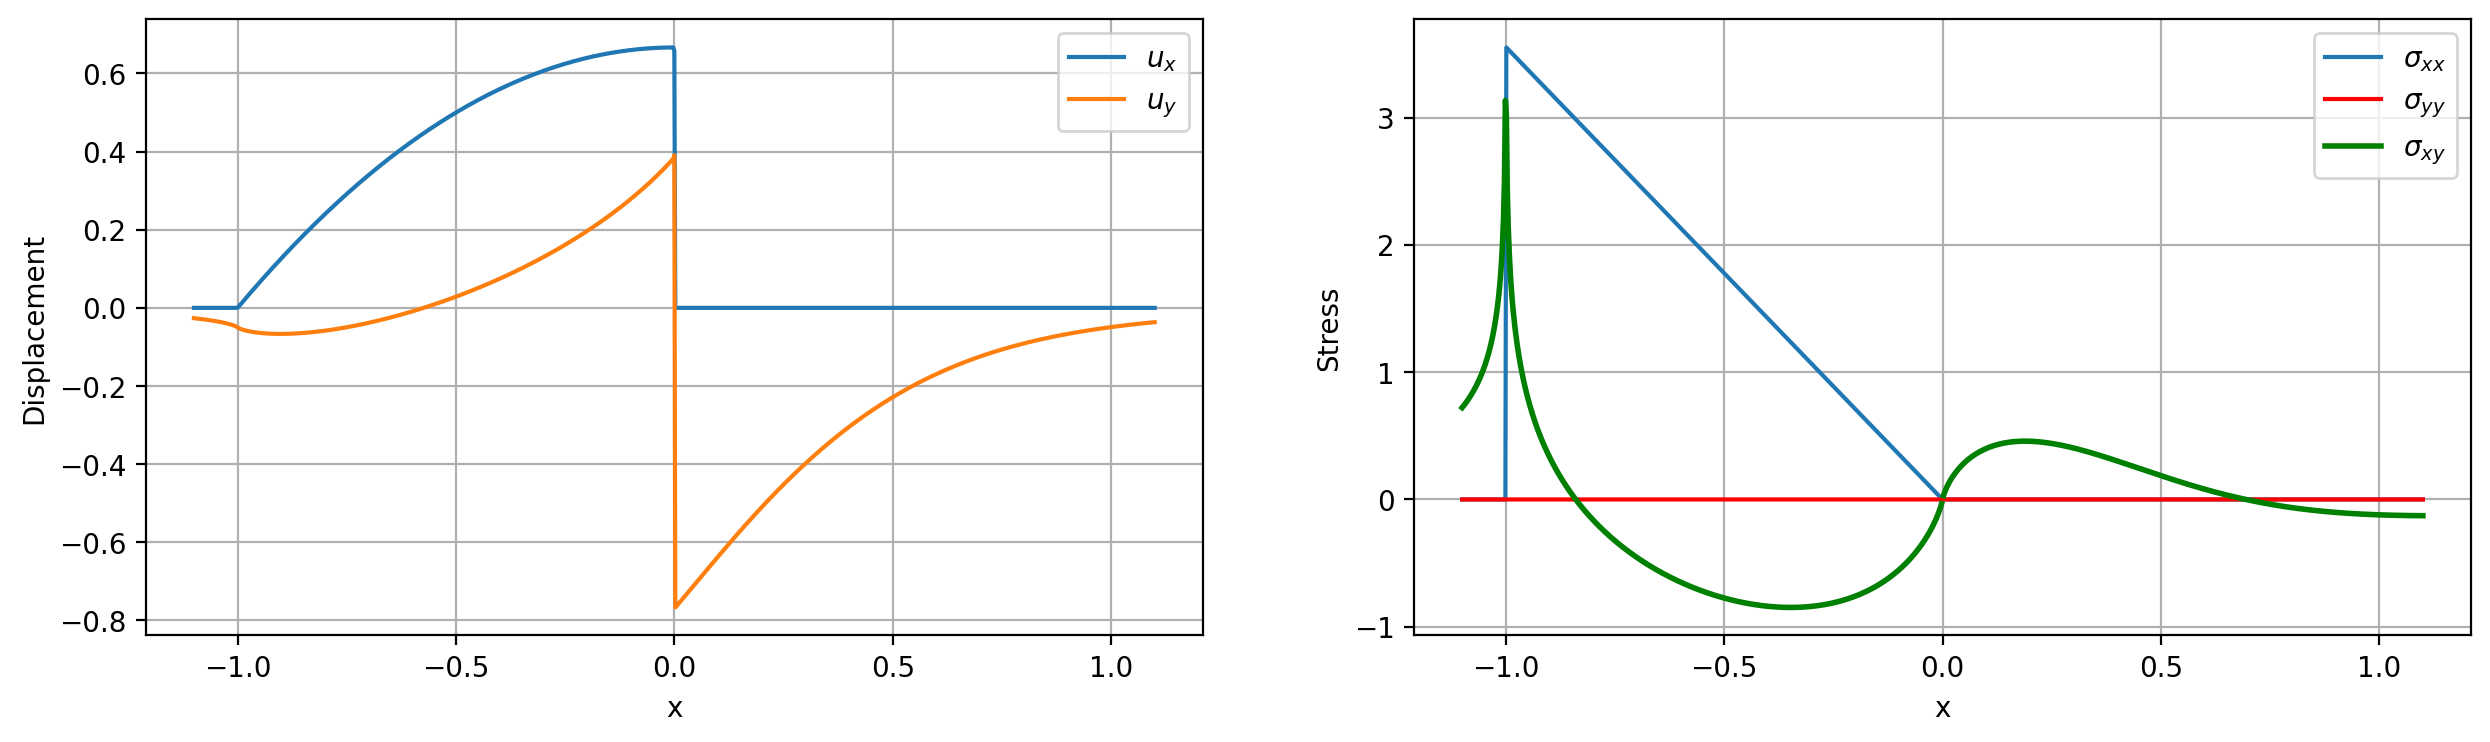

In [6]:
# Compute displacements along a line
x_obs = np.linspace(-1.1, 1.1, 1001).reshape(-1, 1)
y_obs = 1e-8 + x_obs * 0

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# Compute displacement and stresses (we will plot it later)
ux_a, uy_a, sxx_a, syy_a, sxy_a = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux_a, "-", label="$u_x$")
plt.plot(x_obs, uy_a, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx_a, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy_a, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy_a, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()

#### Case A: Areal displacements and stresses

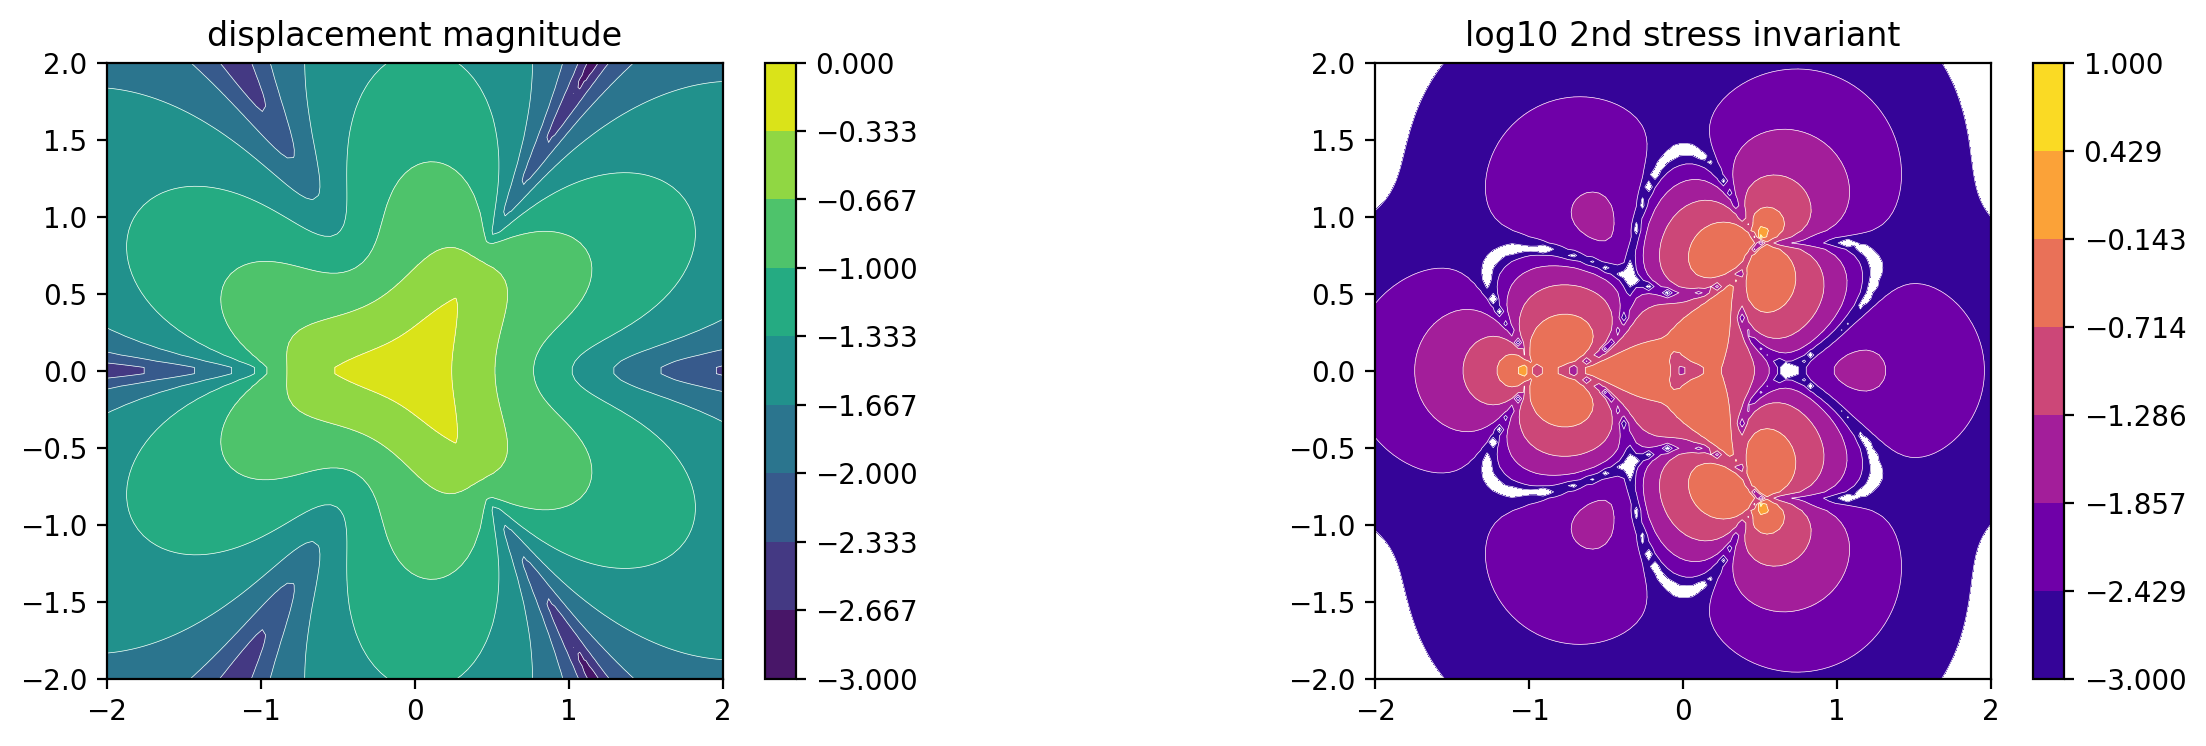

In [7]:
def plot_els(els):
    n_els = len(els.x1)
    for i in range(n_els):
        plt.plot(
            [els.x1[i], els.x2[i]],
            [els.y1[i], els.y2[i]],
            "-k",
            linewidth=0.25,
        )


def areal_plots():
    n_obs_pts = 100
    x_obs_vec = np.linspace(-2.0, 2.0, n_obs_pts)
    y_obs_vec = np.linspace(-2.0, 2.0, n_obs_pts)
    # x_obs_vec = np.linspace(-0.2, 0.2, n_obs_pts)
    # y_obs_vec = np.linspace(-0.2, 0.2, n_obs_pts)

    x_obs_mat, y_obs_mat = np.meshgrid(x_obs_vec, y_obs_vec)
    x_obs_mat = x_obs_mat.flatten()
    y_obs_mat = y_obs_mat.flatten()

    # Compute shear and tensile stress kernels
    kernels_s = bemcs.get_displacement_stress_kernel(
        x_obs_mat, y_obs_mat, els, mu, nu, flag="shear"
    )
    kernels_n = bemcs.get_displacement_stress_kernel(
        x_obs_mat, y_obs_mat, els, mu, nu, flag="normal"
    )

    # Compute and plot displacement and stresses
    ux_mat, uy_mat, sxx_mat, syy_mat, sxy_mat = bemcs.coeffs_to_disp_stress(
        kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
    )
    bemcs.plot_displacements_stresses_els(
        els,
        n_obs_pts,
        ux_mat,
        uy_mat,
        sxx_mat,
        syy_mat,
        sxy_mat,
        x_obs_mat,
        y_obs_mat,
        n_skip_plot=13,
    )

    # Plot velocity magnitudes
    u_mag = np.sqrt(ux_mat**2.0 + uy_mat**2.0)
    s_second_invariant = sxx_mat * syy_mat - sxy_mat**2.0
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    levels = np.linspace(-3, 0, 10)
    plt.title("displacement magnitude")
    plt.contourf(
        x_obs_mat.reshape(n_obs_pts, n_obs_pts),
        y_obs_mat.reshape(n_obs_pts, n_obs_pts),
        np.log10(u_mag.reshape(n_obs_pts, n_obs_pts)),
        levels=levels,
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.contour(
        x_obs_mat.reshape(n_obs_pts, n_obs_pts),
        y_obs_mat.reshape(n_obs_pts, n_obs_pts),
        np.log10(u_mag.reshape(n_obs_pts, n_obs_pts)),
        levels=levels,
        linewidths=0.25,
        linestyles="-",
        colors="w",
    )
    # plot_els(els)
    plt.gca().set_aspect("equal", adjustable="box")

    plt.subplot(1, 2, 2)
    # levels = np.array([-4, -3, -2, -1, 0, 1, 2])
    levels = np.linspace(-3, 1, 8)
    plt.title("log10 2nd stress invariant")
    plt.contourf(
        x_obs_mat.reshape(n_obs_pts, n_obs_pts),
        y_obs_mat.reshape(n_obs_pts, n_obs_pts),
        np.log10(np.abs(s_second_invariant.reshape(n_obs_pts, n_obs_pts))),
        levels=levels,
        cmap="plasma",
        vmin=-3,
        vmax=1,
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.contour(
        x_obs_mat.reshape(n_obs_pts, n_obs_pts),
        y_obs_mat.reshape(n_obs_pts, n_obs_pts),
        np.log10(np.abs(s_second_invariant.reshape(n_obs_pts, n_obs_pts))),
        levels=levels,
        linewidths=0.25,
        linestyles="-",
        colors="w",
    )
    plt.clim(-3, 1)
    # plot_els(els)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()
    return ux_mat, uy_mat, sxx_mat, syy_mat, sxy_mat, u_mag, s_second_invariant


(
    ux_a_mat,
    uy_a_mat,
    sxx_a_mat,
    syy_a_mat,
    sxy_a_mat,
    u_mag_a_mat,
    s_second_invariant_a_mat,
) = areal_plots()

# Case B
- Continuity of slip at a triple junction using element by element pairing.  This is essentially what we do for the two element case and there is no direct notion of a triple junction in the math here.

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) = 0$     | elements 1, 2: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) = 0$     | elements 1, 2: continuity of $y$ slip at a triple junction   |
| 15  | $p^x_1(n_3) - p^x_3(n_1) = 0$     | elements 1, 3: continuity of $x$ slip at a triple junction   |
| 16  | $p^y_1(n_3) - p^y_3(n_1) = 0$     | elements 1, 3: continuity of $y$ slip at a triple junction   |
| 17  | $p^x_2(n_3) - p^x_3(n_1) = 0$     | elements 2, 3: continuity of $x$ slip at a triple junction   |
| 18  | $p^y_2(n_3) - p^y_3(n_1) = 0$     | elements 2, 3: continuity of $y$ slip at a triple junction   |


#### Pros:
Slip is continuous

#### Cons:
Singular stresses at the triple junction



# Case C
- Continuity of slip at a triple junction 
- Smoothness of slip between 2 selected elements that share the triple junction
- Set the slip gradient for the third element to 0

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $\partial p^x_1(n_3) / \partial x - \partial p^x_2(n_1) / \partial x - \partial p^x_3(n_1) / \partial x = 0$ | elements 1, 2, 3: continuity of $x$ slip gradient at a triple junction |
| 16  | $\partial p^y_1(n_3) / \partial y - \partial p^y_2(n_1) / \partial y - \partial p^y_3(n_1) / \partial y = 0$ | elements 1, 2, 3: continuity of $y$ slip gradient at a triple junction |
| 17  | $\partial p^x_3(n_1) / \partial x = 0$ or $ \partial p^x_2(n_1) / \partial x = 0$ | elements 2 or 3: continuity of $x$ slip gradient at a triple junction |
| 18  | $\partial p^y_3(n_1) / \partial y = 0$ or $ \partial p^y_2(n_1) / \partial y = 0$ | elements 2 or 3: continuity of $y$ slip gradient at a triple junction |

#### Pros:
- Non-singular 
- Continuous displacements and stresses!!! (### realization on 27th July 2023 - this is not true. It was only true because we were looking at co-planar elements)

#### Cons:
- Bizarre extra boundary condition
- Extra boundary condtion has to be on elements 2 or 3 but not element 1.  If BC is on element 1, need to change the order of the slip conservation equation


Linear Operator Condition Number: 37.573627802643024


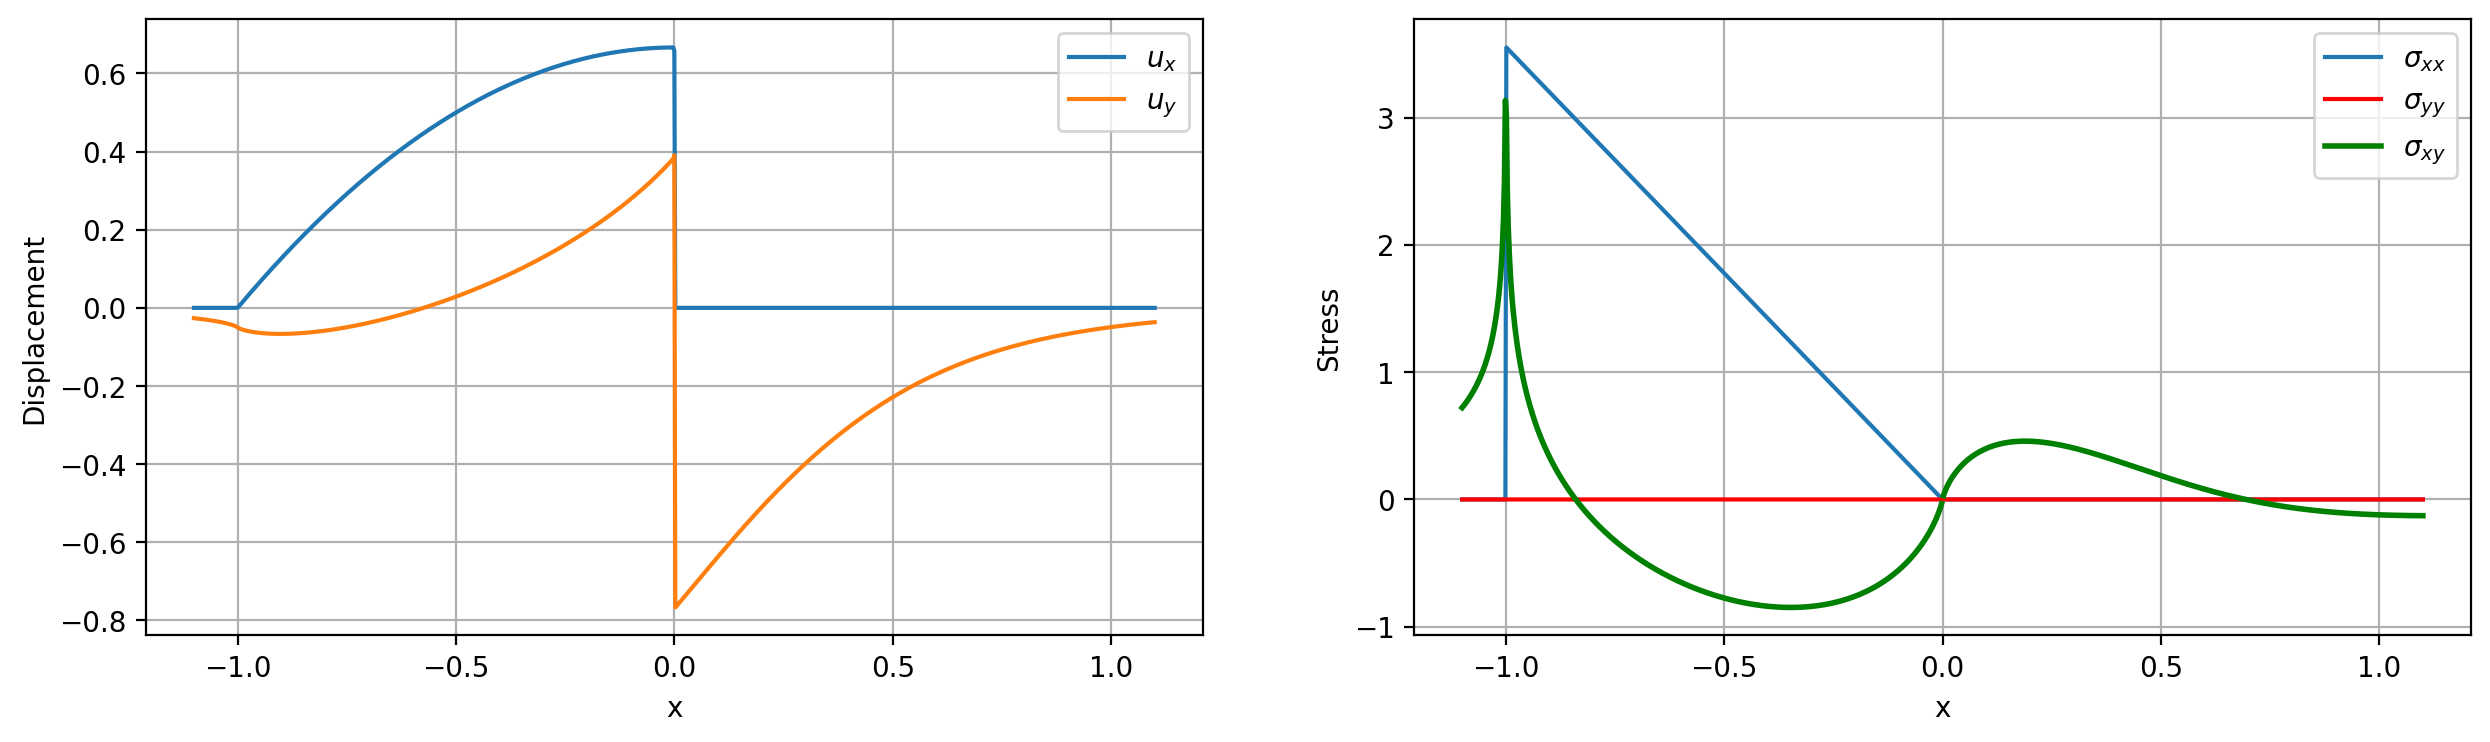

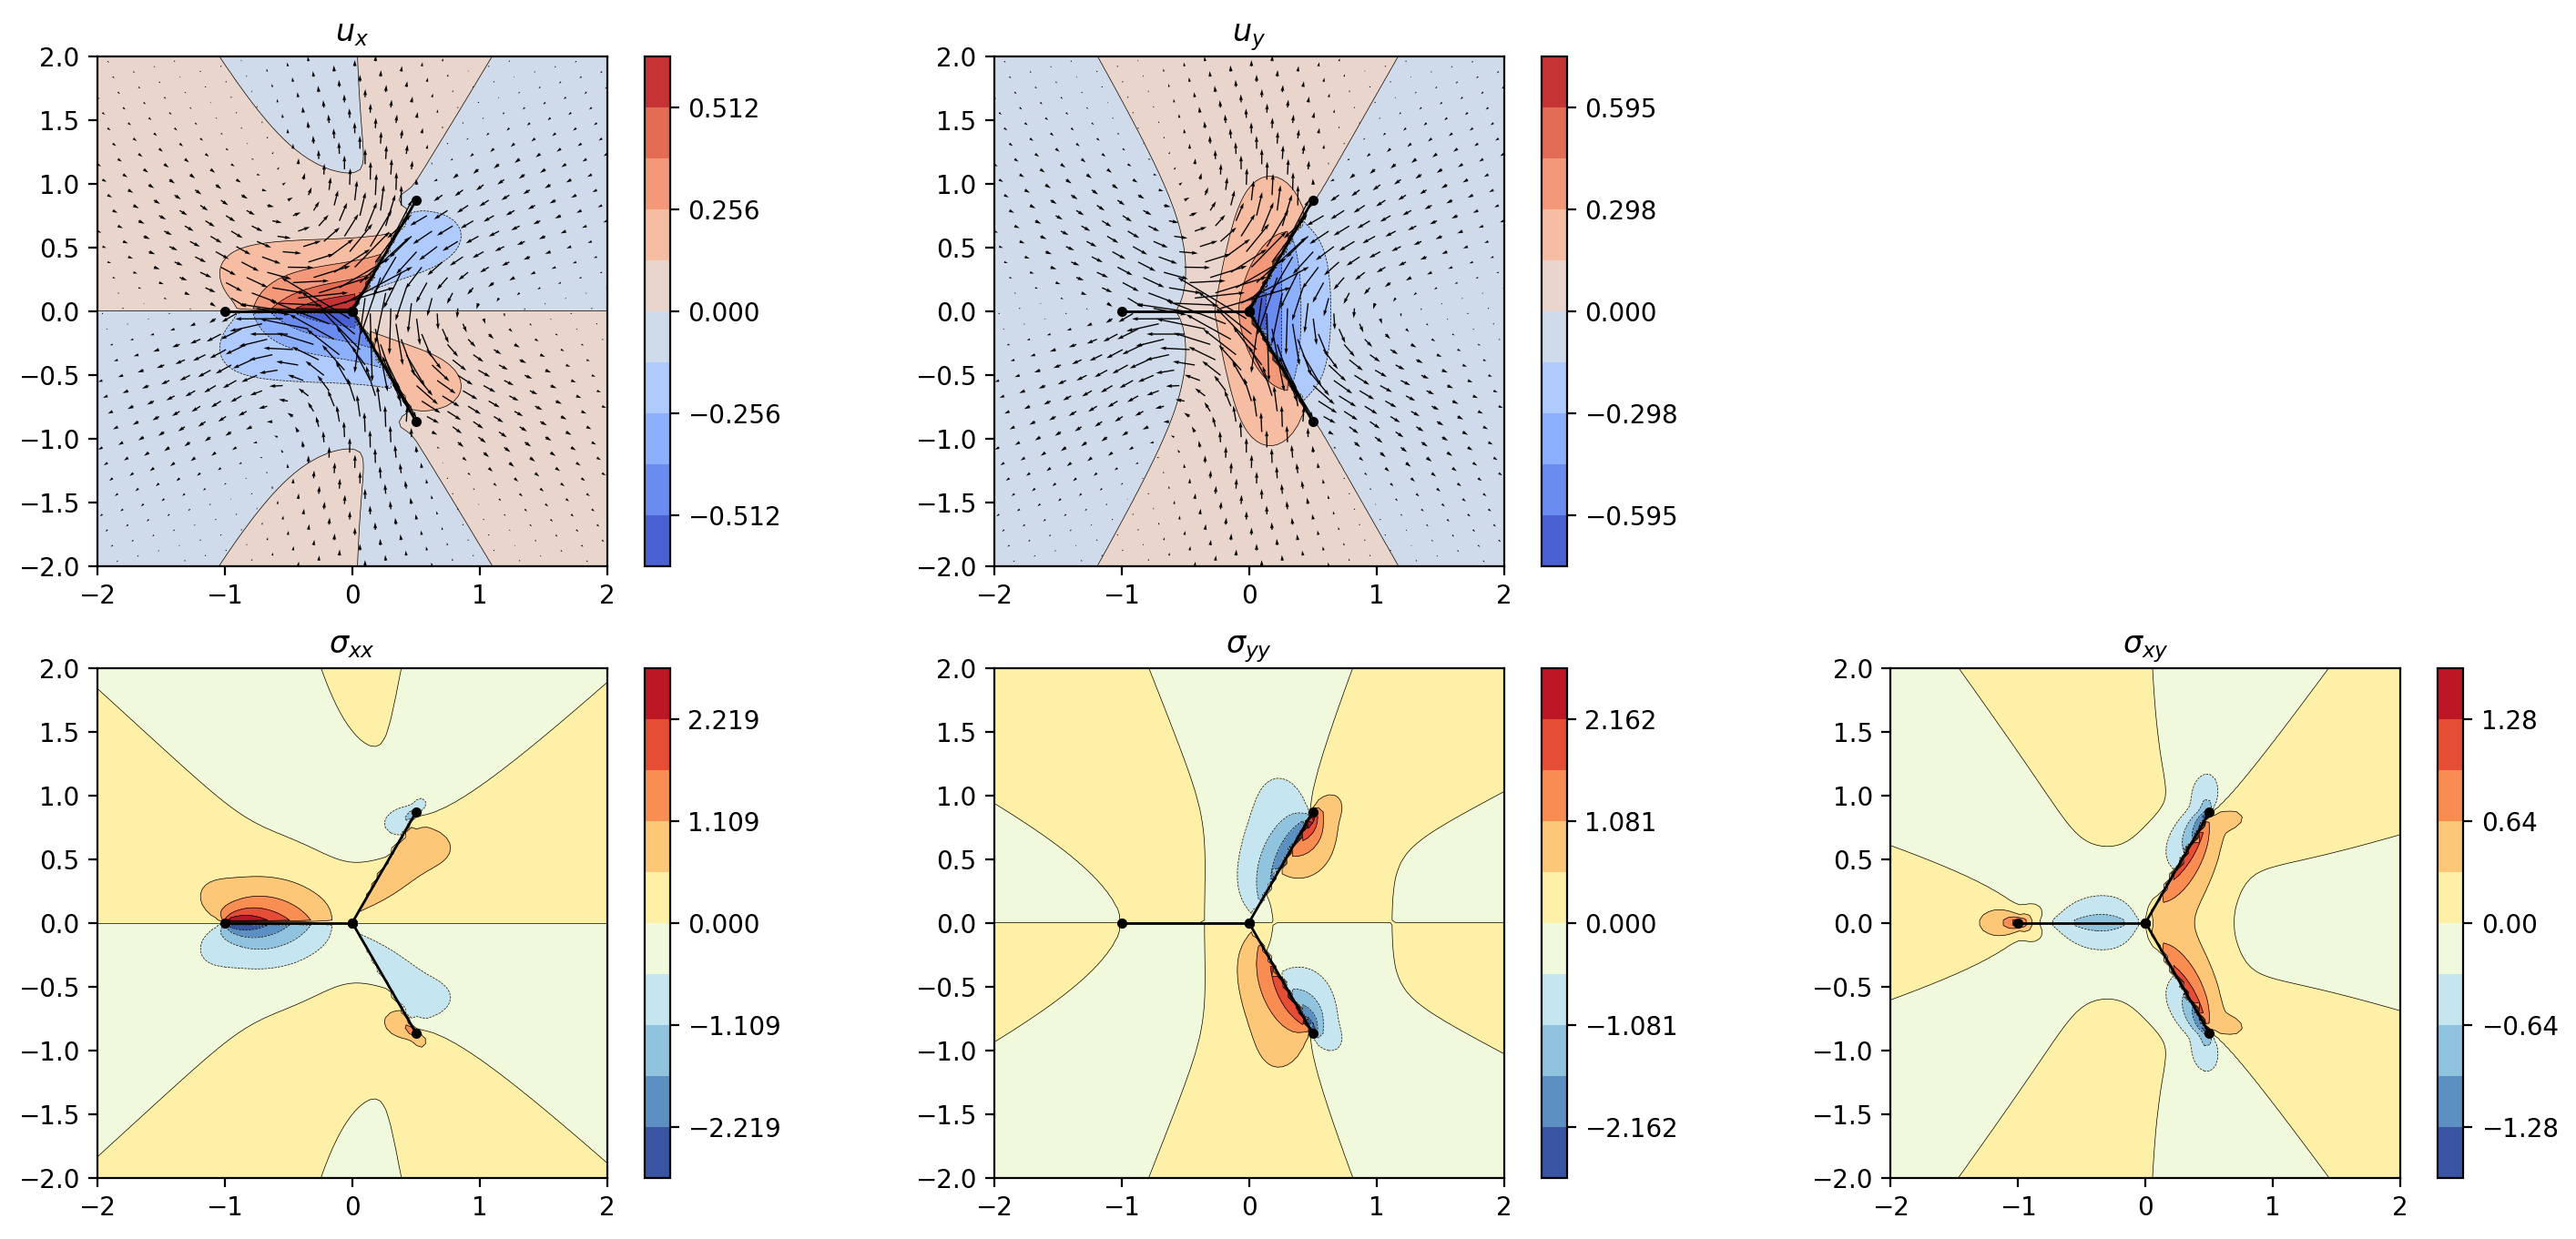

In [8]:
slip_system_mat = np.zeros((n_equations, n_unknowns))

bc_vec = np.zeros((n_equations, 1))
bc_vec[2::6] = slip_x_vec.reshape((-1, 1))
bc_vec[3::6] = slip_y_vec.reshape((-1, 1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
slip_system_mat[0:2, :] = slip_mat[0:2:]  # first element open node
slip_system_mat[10:12, :] = slip_mat[10:12:]  # second element open node
slip_system_mat[16:18, :] = slip_mat[16:18, :]  # last element open node

# patch center nodes (for x,y components)
slip_system_mat[2::6, :] = slip_mat[2::6, :]  # x component
slip_system_mat[3::6, :] = slip_mat[3::6, :]  # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
slip_system_mat[4, :] = slip_mat[4, :] - slip_mat[6, :] - slip_mat[12, :]  # x component
slip_system_mat[5, :] = slip_mat[5, :] - slip_mat[7, :] - slip_mat[13, :]  # y component

# triple junction equation of smoothness
slip_system_mat[6, :] = (
    slip_gradient_mat[4, :] - slip_gradient_mat[6, :] - slip_gradient_mat[12, :]
)
slip_system_mat[7, :] = (
    slip_gradient_mat[5, :] - slip_gradient_mat[7, :] - slip_gradient_mat[13, :]
)

# testing additional constraints
# slip_system_mat[12,:] = slip_matgradient[6,:]
# slip_system_mat[13,:] = slip_matgradient[7,:]
slip_system_mat[12, :] = slip_gradient_mat[12, :]
slip_system_mat[13, :] = slip_gradient_mat[13, :]

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(slip_system_mat) @ bc_vec
print("Linear Operator Condition Number:", np.linalg.cond(slip_system_mat))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# compute displacement and stresses (we will plot it later)
ux_c, uy_c, sxx_c, syy_c, sxy_c = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux_c, "-", label="$u_x$")
plt.plot(x_obs, uy_c, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx_c, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy_c, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy_c, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()

(
    ux_c_mat,
    uy_c_mat,
    sxx_c_mat,
    syy_c_mat,
    sxy_c_mat,
    u_mag_c_mat,
    s_second_invariant_c_mat,
) = areal_plots()

# Case D

- Continuity of slip at a triple junction 
- Smoothness of slip implemented as continuity of the Jacobian of slip instead of the directional derivative of slip 
 
The Jacobian of slip in terms of slip gradients in the fault-centric coordinates $\frac{\partial s_s}{\partial \zeta}, \frac{\partial s_n}{\partial \zeta}$ is 

$\begin{aligned} R^T (\nabla\underline{s}) R & = \begin{bmatrix} d_x & n_x \\ d_z & n_z \end{bmatrix}\begin{bmatrix} \frac{\partial s_s}{\partial \zeta} & 0 \\ \frac{\partial s_n}{\partial \zeta} & 0\end{bmatrix}\begin{bmatrix} d_x & d_z \\ n_x & n_z \end{bmatrix} \\
& = \begin{bmatrix} \frac{\partial s_s}{\partial\zeta}d_x^2 + \frac{\partial s_n}{\partial\zeta}d_x n_x & 
\frac{\partial s_s}{\partial\zeta}d_x d_z + \frac{\partial s_n}{\partial\zeta}n_x d_z \\
\frac{\partial s_s}{\partial\zeta}d_x d_z + \frac{\partial s_n}{\partial\zeta}n_z d_x & 
\frac{\partial s_s}{\partial\zeta}d_z^2 + \frac{\partial s_n}{\partial\zeta}n_z d_z
\end{bmatrix}\end{aligned}$

where $d_x,d_z$ is the unit vector for the shear direction and $n_x,n_z$ is in the normal direction.

Note that when we calculated `slip_gradient_mat`, we already got $ \begin{bmatrix} d_x & n_x \\ d_z & n_z \end{bmatrix}\begin{bmatrix} \frac{\partial s_s}{\partial \zeta} & 0 \\ \frac{\partial s_n}{\partial \zeta} & 0\end{bmatrix} = \begin{bmatrix} \frac{\partial s_x}{\partial \zeta} & 0 \\ \frac{\partial s_z}{\partial \zeta} & 0\end{bmatrix}$, so the 4 equations we need are in terms of conservation of the following matrix:

$\begin{bmatrix} \frac{\partial s_x}{\partial \zeta}d_x & \frac{\partial s_x}{\partial \zeta}d_z \\ \frac{\partial s_z}{\partial \zeta}d_x & \frac{\partial s_z}{\partial \zeta}d_z\end{bmatrix}$


| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $(\nabla s)^{xx}_1(n_3) - (\nabla s)^{xx}_2(n_1) - (\nabla s)^{xx}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $xx$ slip gradient at a triple junction |
| 16  | $(\nabla s)^{xy}_1(n_3) - (\nabla s)^{xy}_2(n_1) - (\nabla s)^{xy}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $xy$ slip gradient at a triple junction |
| 17  | $(\nabla s)^{yx}_1(n_3) - (\nabla s)^{yx}_2(n_1) - (\nabla s)^{yx}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $yx$ slip gradient at a triple junction |
| 18  | $(\nabla s)^{yy}_1(n_3) - (\nabla s)^{yy}_2(n_1) - (\nabla s)^{yy}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $yy$ slip gradient at a triple junction |

#### Pros:
- This is the most general case theoretically, and is the true set of equations describing continuity of slip gradients

#### Cons:
- It ONLY makes sense for triple junctions. 
- Provides 2 more equations than needed for typical 2-overlapping elements
- Does not provide enough equations when more than 3 elements meet at a junction


Linear Operator Condition Number: 23.497831099253027


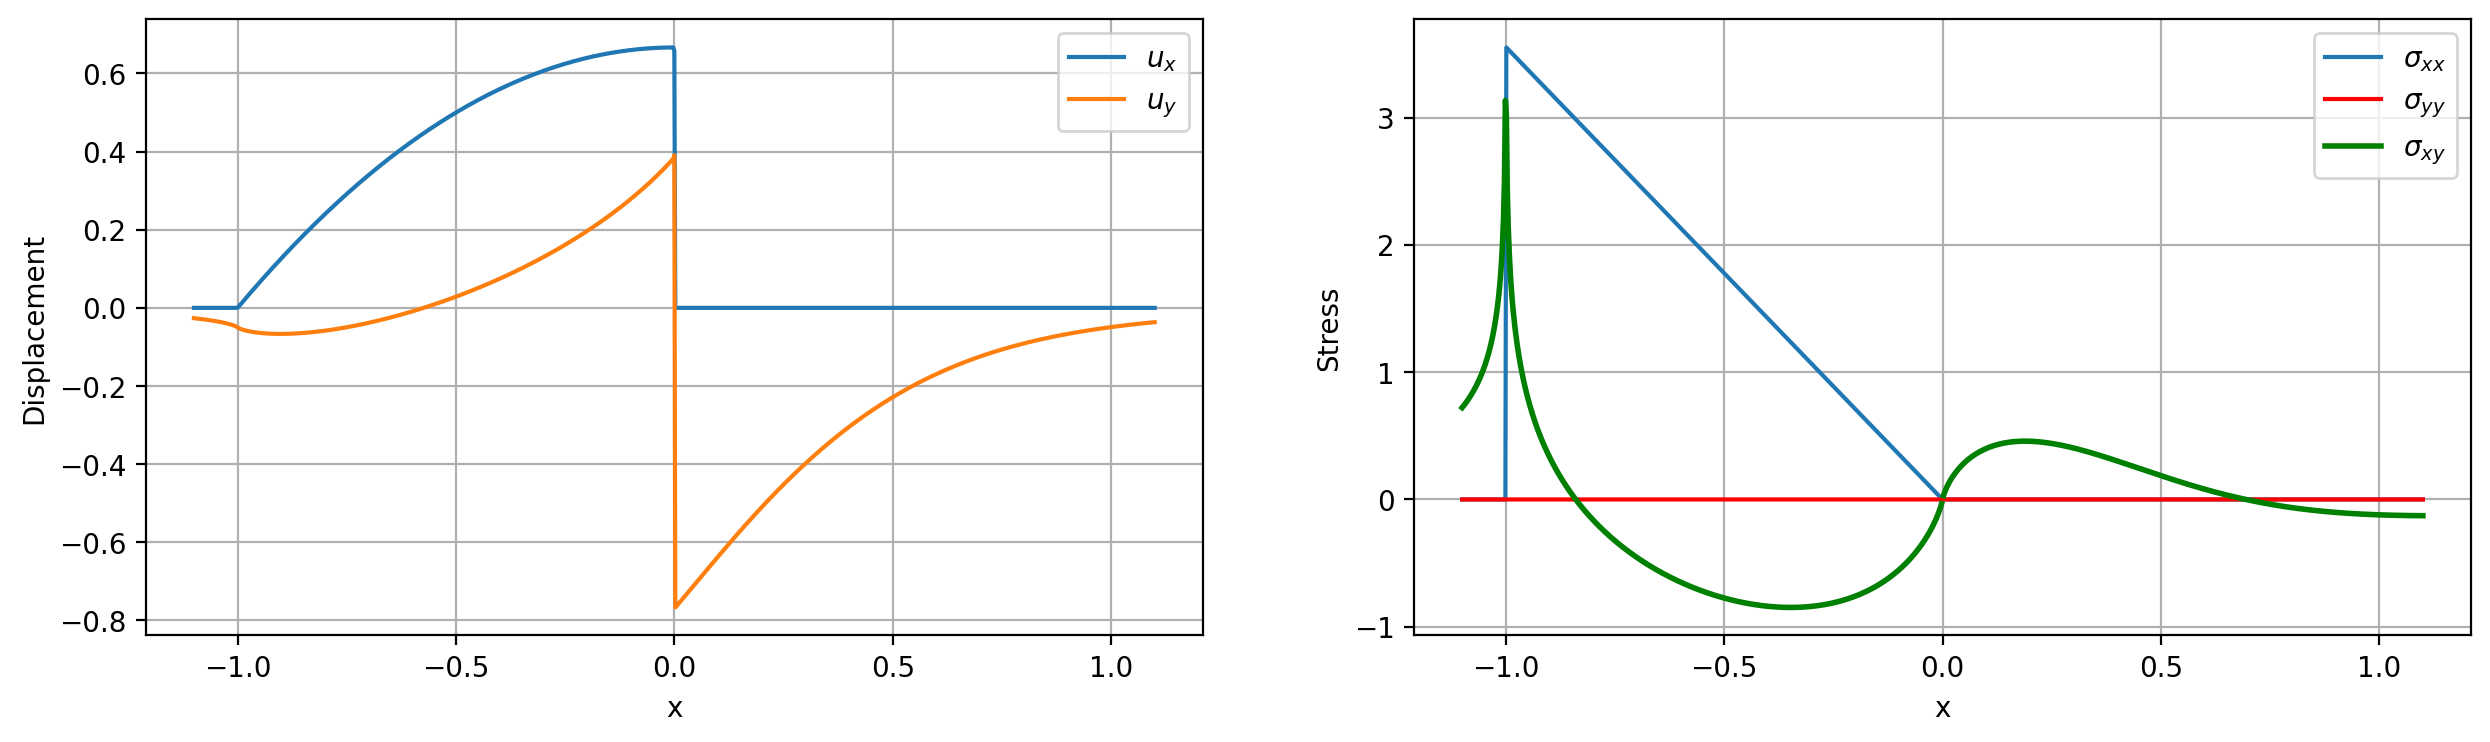

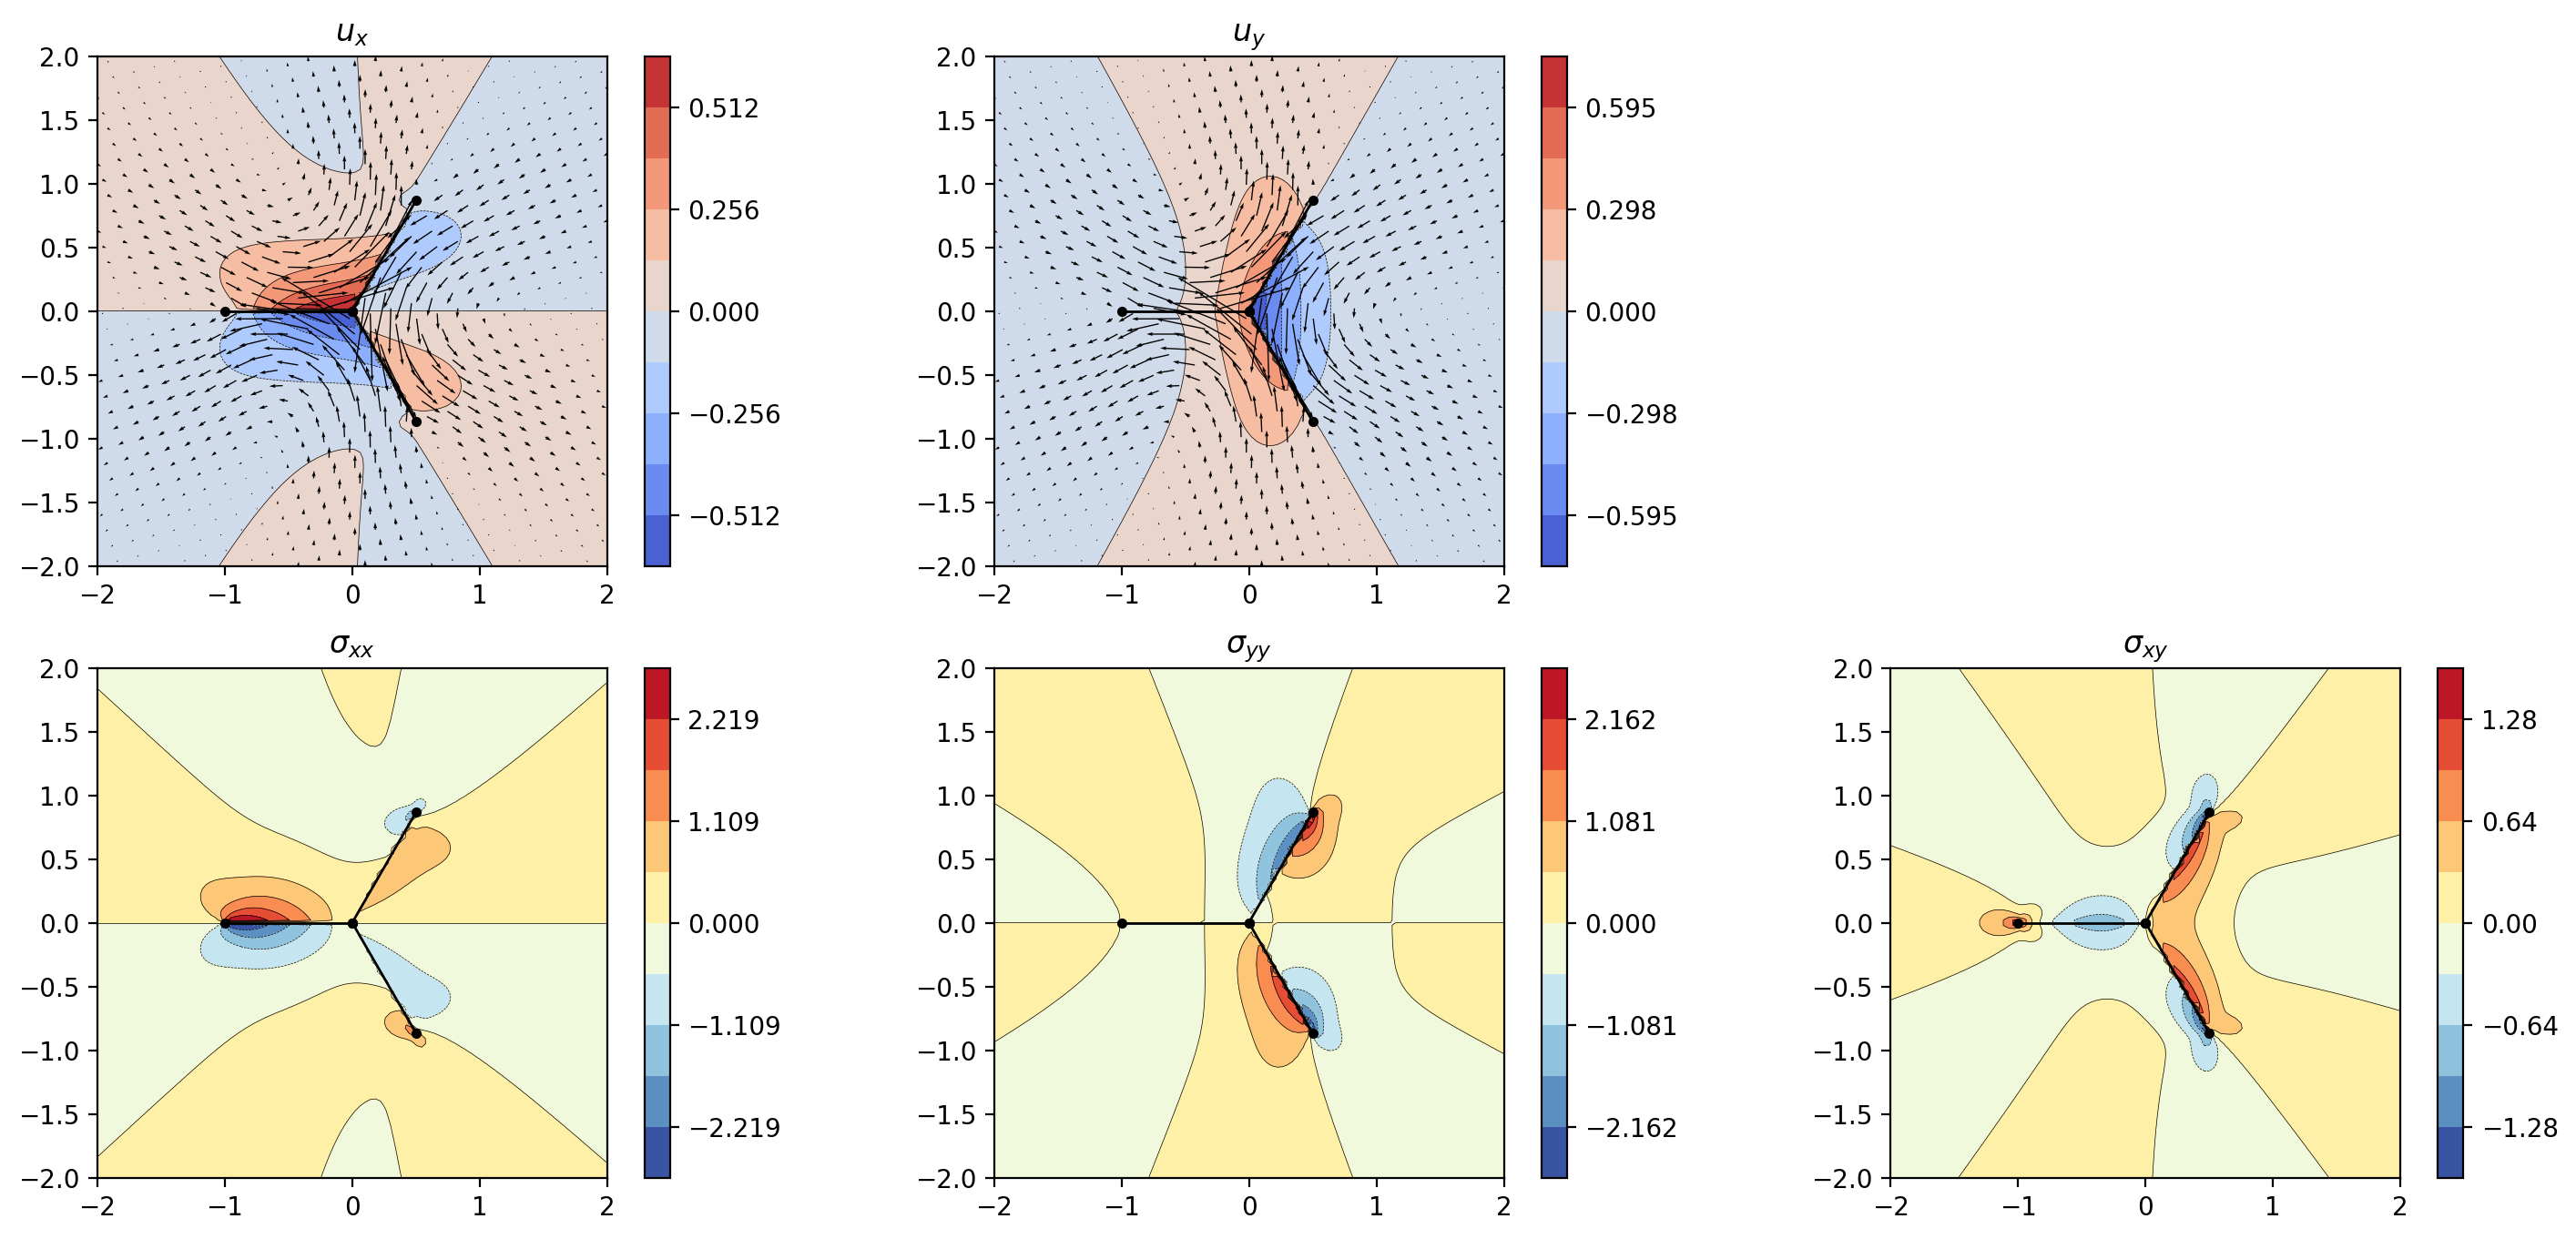

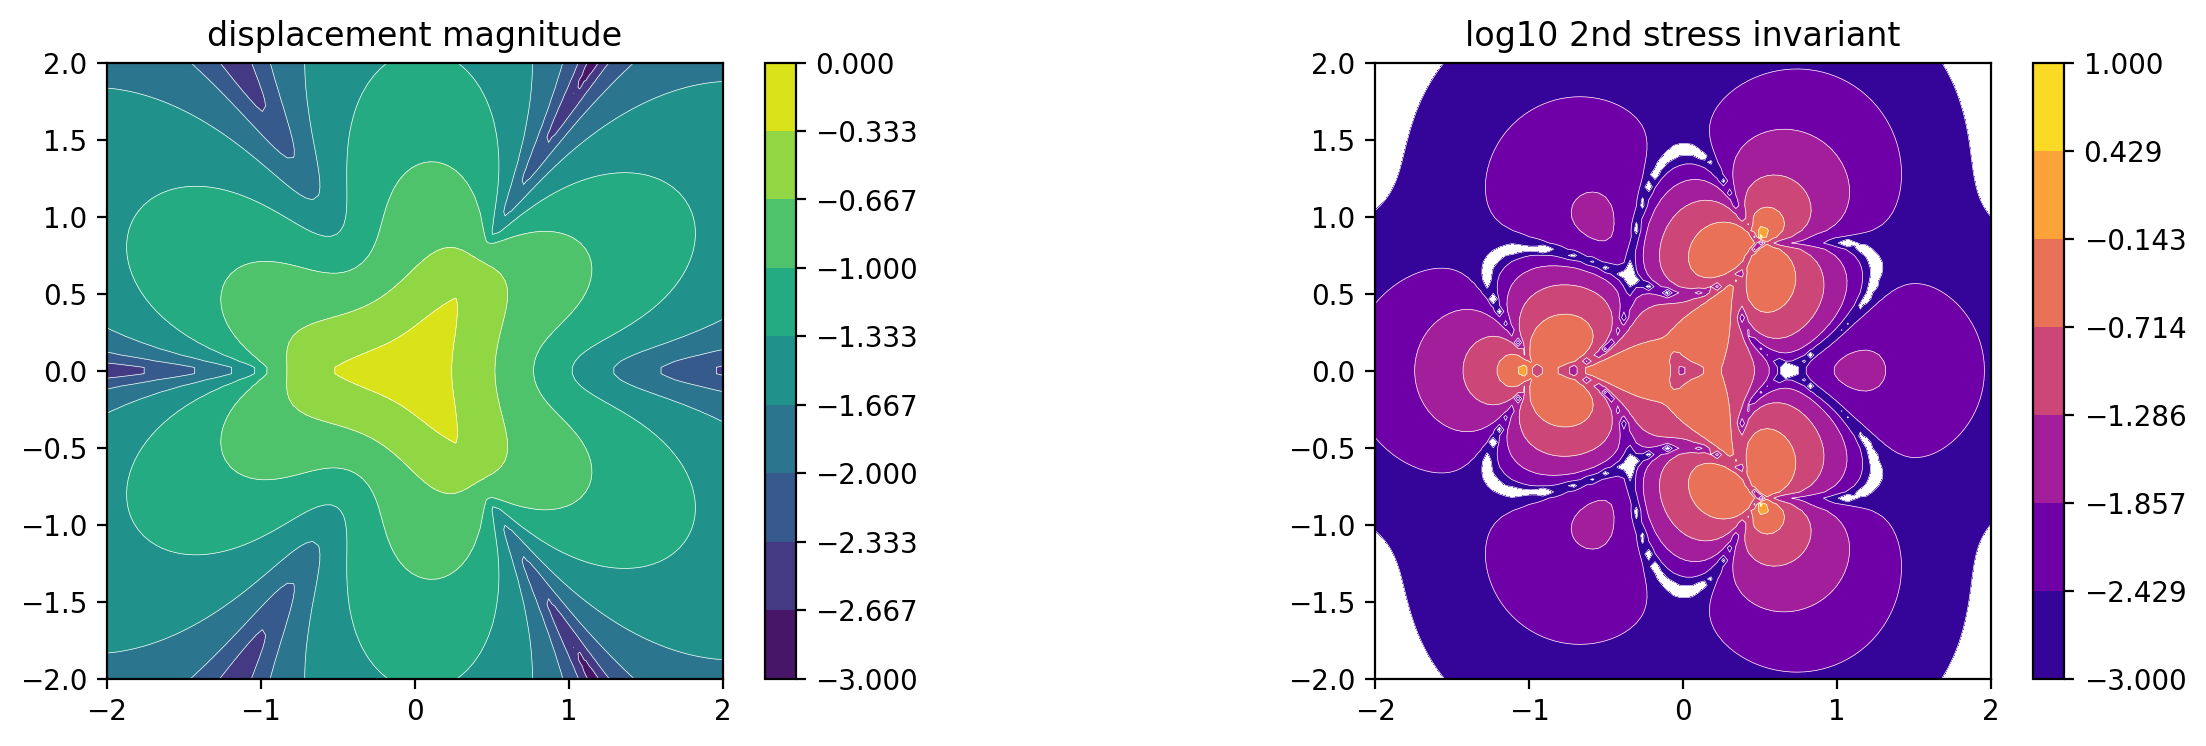

In [9]:
slip_system_mat = np.zeros((n_equations, n_unknowns))

bc_vec = np.zeros((n_equations, 1))
bc_vec[2::6] = slip_x_vec.reshape((-1, 1))
bc_vec[3::6] = slip_y_vec.reshape((-1, 1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
slip_system_mat[0:2, :] = slip_mat[0:2:]  # first element open node
slip_system_mat[10:12, :] = slip_mat[10:12:]  # second element open node
slip_system_mat[16:18, :] = slip_mat[16:18, :]  # last element open node

# patch center nodes (for x,y components)
slip_system_mat[2::6, :] = slip_mat[2::6, :]  # x component
slip_system_mat[3::6, :] = slip_mat[3::6, :]  # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
slip_system_mat[4, :] = slip_mat[4, :] - slip_mat[6, :] - slip_mat[12, :]  # x component
slip_system_mat[5, :] = slip_mat[5, :] - slip_mat[7, :] - slip_mat[13, :]  # y component

# triple junction equation of smoothness (Jacobian form)
slip_system_mat[6, :] = (
    slip_gradient_mat[4, :] * els.x_shears[0]
    - slip_gradient_mat[6, :] * els.x_shears[1]
    - slip_gradient_mat[12, :] * els.x_shears[2]
)
slip_system_mat[7, :] = (
    slip_gradient_mat[4, :] * els.y_shears[0]
    - slip_gradient_mat[6, :] * els.y_shears[1]
    - slip_gradient_mat[12, :] * els.y_shears[2]
)
slip_system_mat[12, :] = (
    slip_gradient_mat[5, :] * els.x_shears[0]
    - slip_gradient_mat[7, :] * els.x_shears[1]
    - slip_gradient_mat[13, :] * els.x_shears[2]
)
slip_system_mat[13, :] = (
    slip_gradient_mat[5, :] * els.y_shears[0]
    - slip_gradient_mat[7, :] * els.y_shears[1]
    - slip_gradient_mat[13, :] * els.y_shears[2]
)

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(slip_system_mat) @ bc_vec
print("Linear Operator Condition Number:", np.linalg.cond(slip_system_mat))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# compute displacement and stresses (we will plot it later)
ux_d, uy_d, sxx_d, syy_d, sxy_d = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux_d, "-", label="$u_x$")
plt.plot(x_obs, uy_d, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx_d, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy_d, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy_d, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()

(
    ux_d_mat,
    uy_d_mat,
    sxx_d_mat,
    syy_d_mat,
    sxy_d_mat,
    u_mag_d_mat,
    s_second_invariant_d_mat,
) = areal_plots()

# Compare results from cases A, C, and D

In [10]:
# Plot Displacements
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux_a, "-", label="case A", linewidth=3)
plt.plot(x_obs, ux_c, "g--", label="case C")
plt.plot(x_obs, ux_d, "r-", label="case D")
plt.grid()
plt.xlabel("x")
plt.ylabel("$u_x$")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_obs, uy_a, "-", linewidth=3)
plt.plot(x_obs, uy_c, "g--")
plt.plot(x_obs, uy_d, "r-")
plt.grid()
plt.xlabel("x")
plt.ylabel("$u_y$")
plt.show()

# Plot Stresses
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(x_obs, sxx_a, "-", label="case A", linewidth=3)
plt.plot(x_obs, sxx_c, "g--", label="case C")
plt.plot(x_obs, sxx_d, "r-", label="case D")
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{xx}$")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x_obs, syy_a, "-", linewidth=3)
plt.plot(x_obs, syy_c, "g--")
plt.plot(x_obs, syy_d, "r-")
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
plt.plot(x_obs, sxy_a, "-", linewidth=3)
plt.plot(x_obs, sxy_c, "g--")
plt.plot(x_obs, sxy_d, "r-")
plt.grid()
plt.xlabel("x")
plt.ylabel("$\sigma_{xy}$")
plt.show()

In [11]:
n_obs_pts = 100
x_obs_vec = np.linspace(-2.0, 2.0, n_obs_pts)
y_obs_vec = np.linspace(-2.0, 2.0, n_obs_pts)
# x_obs_vec = np.linspace(-0.2, 0.2, n_obs_pts)
# y_obs_vec = np.linspace(-0.2, 0.2, n_obs_pts)
x_obs_mat, y_obs_mat = np.meshgrid(x_obs_vec, y_obs_vec)
x_obs_mat = x_obs_mat.flatten()
y_obs_mat = y_obs_mat.flatten()

plt.figure(figsize=(15, 3))

# A-C
plt.subplot(1, 3, 1)
s_second_invariant_mat = s_second_invariant_a_mat - s_second_invariant_c_mat
plt.title("log10 2nd stress invariant (A-C)")
plt.contourf(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    cmap="plasma",
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")

# A-D
plt.subplot(1, 3, 2)
s_second_invariant_mat = s_second_invariant_a_mat - s_second_invariant_d_mat
plt.title("log10 2nd stress invariant (A-D)")
plt.contourf(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    cmap="plasma",
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")

# C-D
plt.subplot(1, 3, 3)
s_second_invariant_mat = s_second_invariant_c_mat - s_second_invariant_d_mat
plt.title("log10 2nd stress invariant (C-D)")
plt.contourf(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    cmap="plasma",
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
    10,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")

plt.show()

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_86373/3650653337.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_86373/3650653337.py:27: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_86373/3650653337.py:43: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_86373/3650653337.py:51: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(s_second_invariant_mat.reshape(n_obs_pts, n_obs_pts))),
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_86373/3650653337.py:67: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(s_second_in

# Is there a way to enforce kinematic consistency just at the center?
- The 120 degree triple junction (TJ) with a set of kinematically consistent slip rates produces streses that are very nearly continuous at the TJ
- This case that inspired this idea is the set of slip rates:
```
slip_x_vec = np.array([1.0, np.cos(np.deg2rad(60)), np.cos(np.deg2rad(60))])
slip_y_vec = np.array([0.0, np.sin(np.deg2rad(60)), -np.sin(np.deg2rad(60))])
```

# The idea so set things at the TJ such that all slip rates are geometrically fixed in some way and modulated only by a constant.  Each set of 3 strike and tensile-slip components would not be able to adjust independently.  Instead there would be a fixed ratio, set by the geometry, and then modulated by the need to satisfy central slip  or mean slip requirements.  This might mean fewer free parameters here.  JUST KICKING AN IDEA AROUND.

# True constant slip example

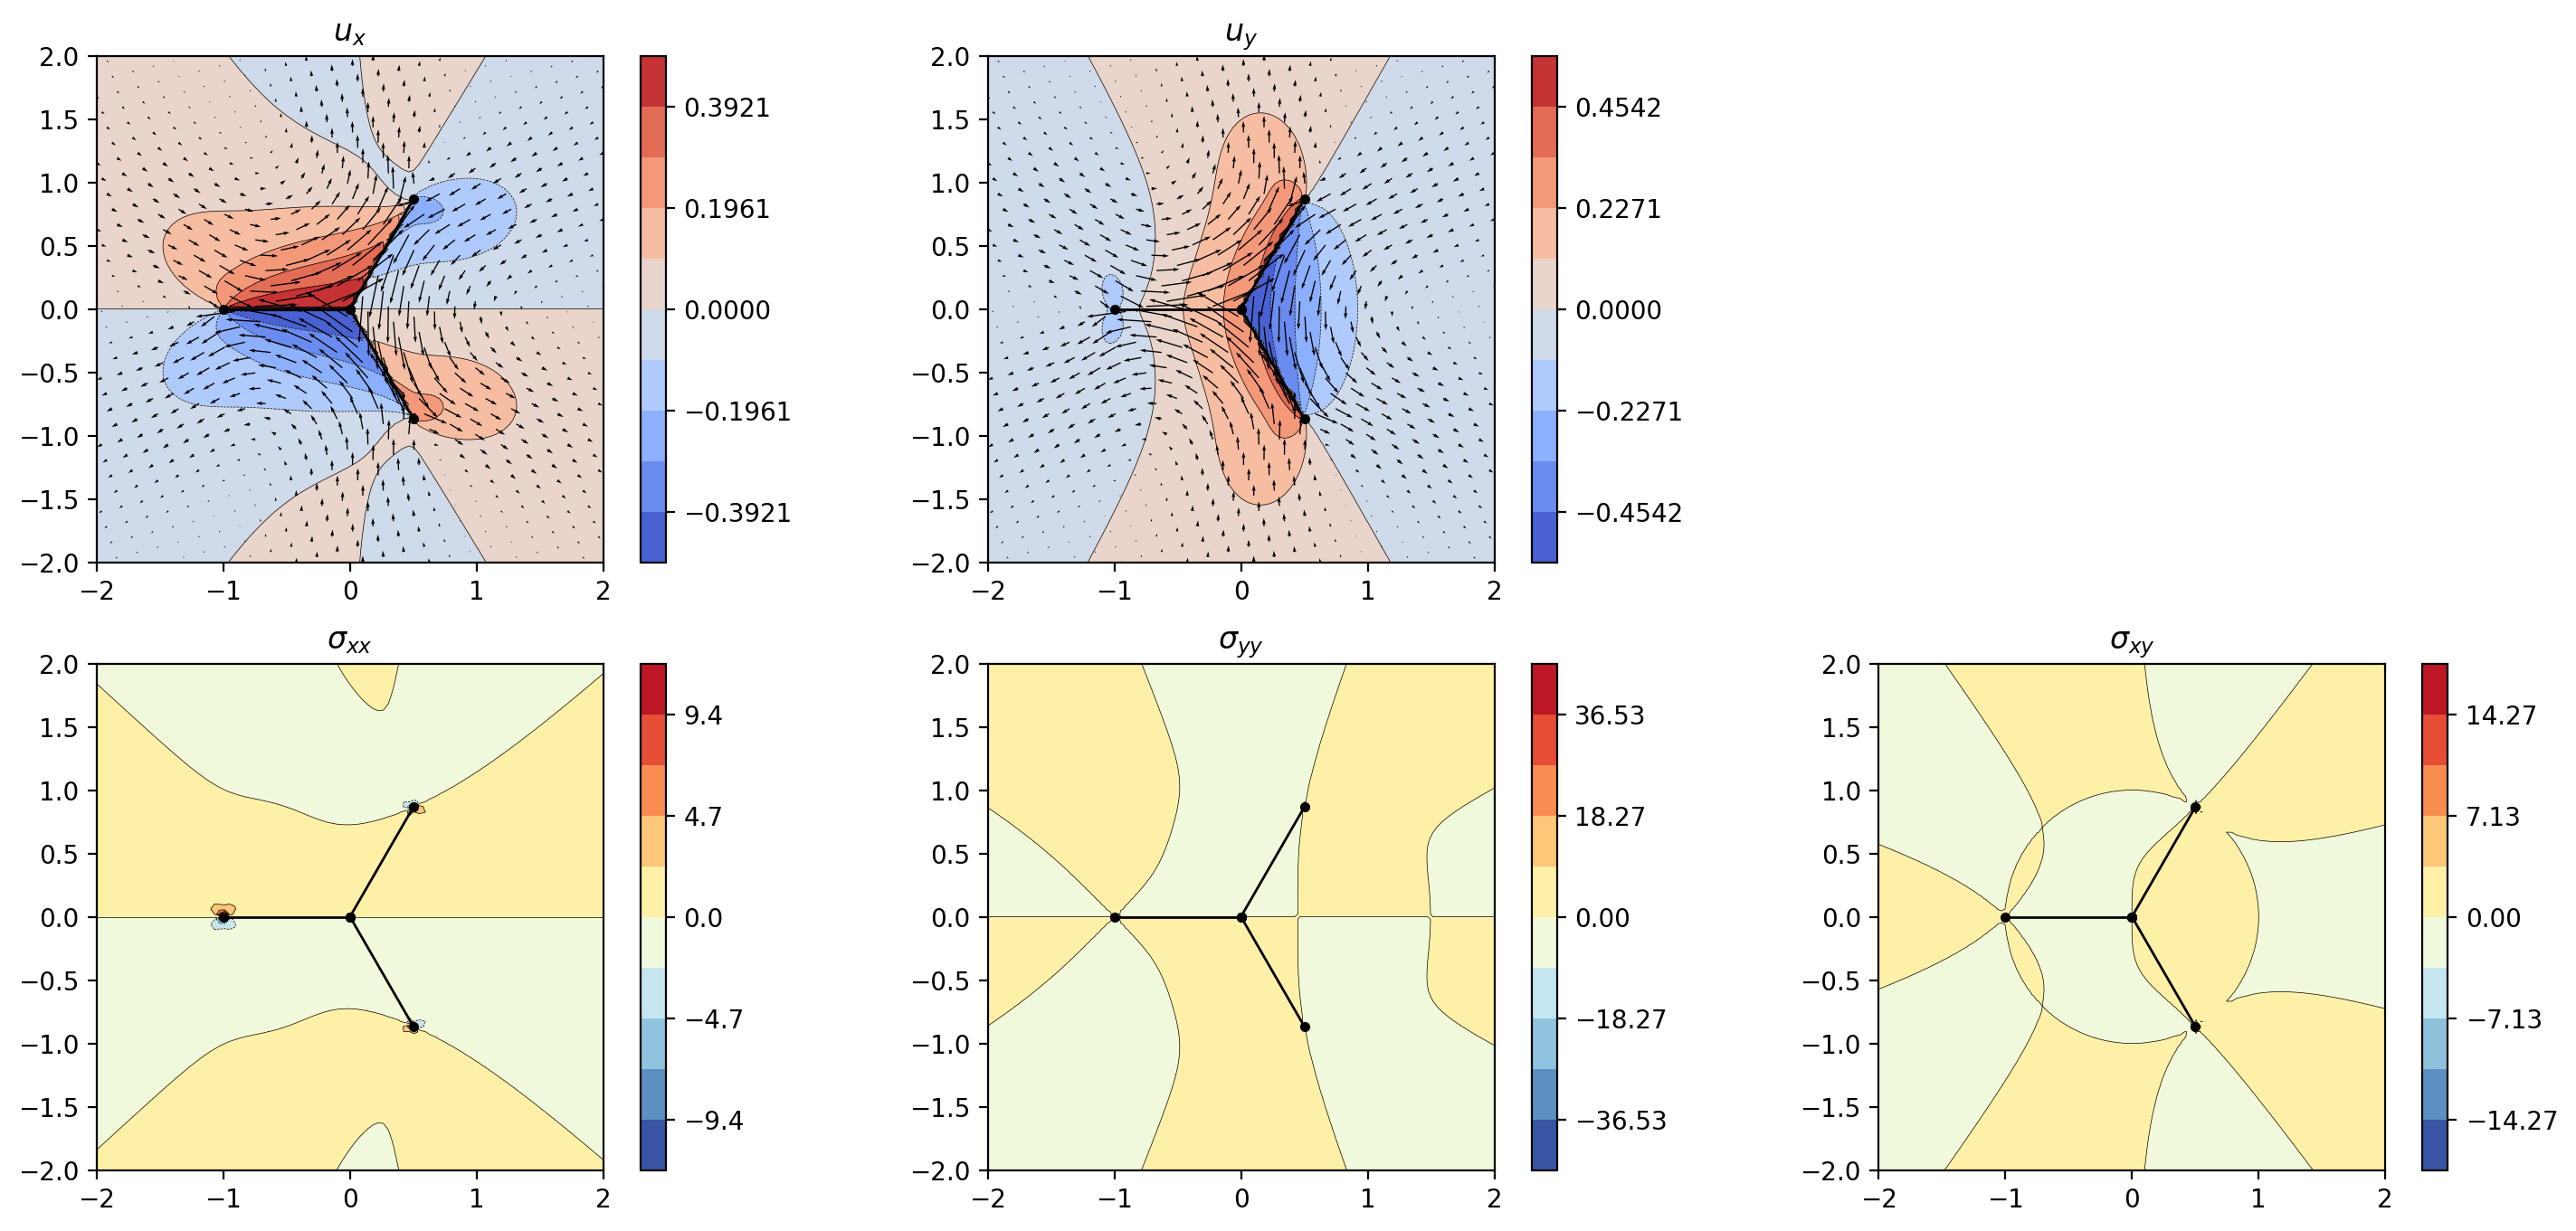

In [12]:
kernels_s_true_constant = bemcs.get_displacement_stress_kernel_constant(
    x_obs_mat, y_obs_mat, els, mu, nu, flag="shear"
)
ux_constant = kernels_s_true_constant[3] @ np.ones((n_els, 1))
uy_constant = kernels_s_true_constant[4] @ np.ones((n_els, 1))
sxx_constant = kernels_s_true_constant[0] @ np.ones((n_els, 1))
syy_constant = kernels_s_true_constant[1] @ np.ones((n_els, 1))
sxy_constant = kernels_s_true_constant[2] @ np.ones((n_els, 1))
u_mag_constant = np.sqrt(ux_constant**2 + uy_constant**2)
s_second_invariant_constant = sxx_constant * syy_constant - sxy_constant**2.0

# Plot in area plots style
bemcs.plot_displacements_stresses_els(
    els,
    n_obs_pts,
    ux_constant,
    uy_constant,
    sxx_constant,
    syy_constant,
    sxy_constant,
    x_obs_mat,
    y_obs_mat,
    n_skip_plot=13,
)

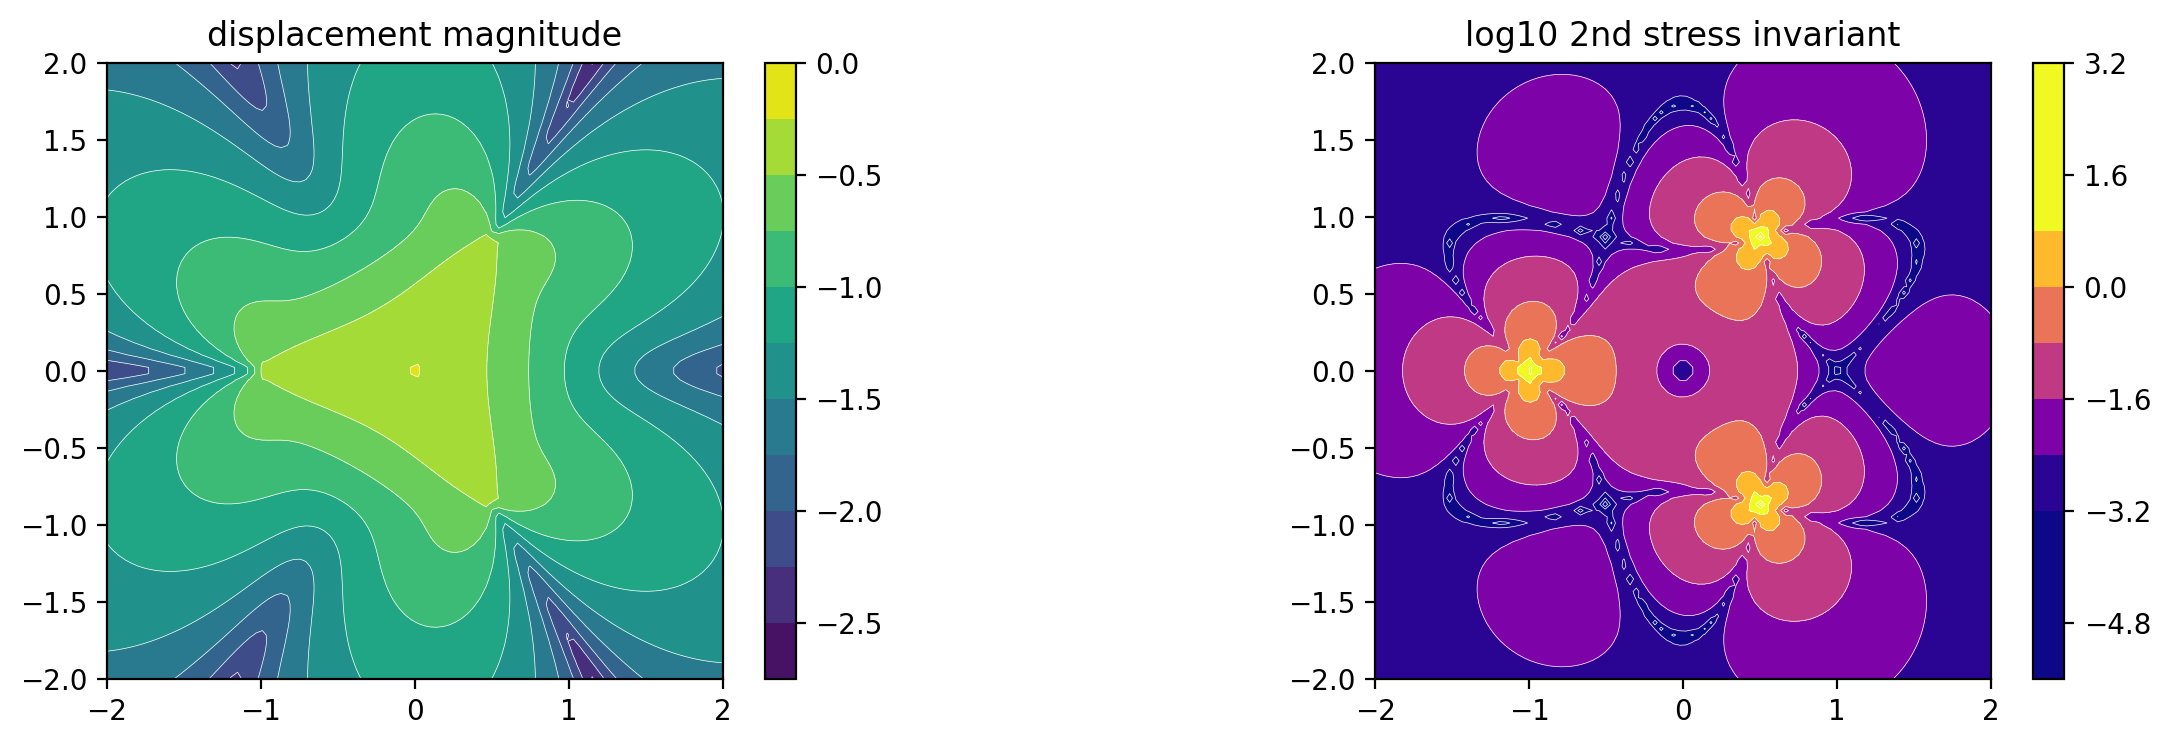

In [13]:
# Plot velocity magnitudes
u_mag = np.sqrt(ux_constant**2.0 + uy_constant**2.0)
s_second_invariant = sxx_constant * syy_constant - sxy_constant**2.0
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("displacement magnitude")
plt.contourf(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(u_mag.reshape(n_obs_pts, n_obs_pts)),
    10,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(u_mag.reshape(n_obs_pts, n_obs_pts)),
    10,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# # plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 2, 2)
plt.title("log10 2nd stress invariant")
plt.contourf(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant.reshape(n_obs_pts, n_obs_pts))),
    10,
    cmap="plasma",
    vmin=-3,
    vmax=1,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-3, 1)
plt.contour(
    x_obs_mat.reshape(n_obs_pts, n_obs_pts),
    y_obs_mat.reshape(n_obs_pts, n_obs_pts),
    np.log10(np.abs(s_second_invariant.reshape(n_obs_pts, n_obs_pts))),
    10,
    linewidths=0.25,
    linestyles="-",
    colors="w",
)
# # plot_els(els)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()